In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Custom functions
from utils_foehn import *

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

# Define constants

In [2]:
# Get base directory which is two levels up
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd())) 
print(BASE_DIR)

/net/litho/atmosdyn2/chmony/develop/FoehnDevelopment


# Read South Foehn datasets and stack

In [3]:
location = "ALT"

In [4]:
# Read first timeperiod (1981-1990) and preprocess
df_1981_1990 = pd.read_csv(os.path.join(BASE_DIR, "data", "FoehnData", f"{location}_1981_1990.dat"), delimiter="\t", header=1)
df_1981_1990["date"] = pd.to_datetime(df_1981_1990["Datumsangabe_Zeit"], format='%Y%m%d %H:%M')
df_1981_1990 = df_1981_1990[["date", "Foehn"]]

In [5]:
# Read second timeperiod (1983-2019) and preprocess
df_1983_2019 = pd.read_csv(os.path.join(BASE_DIR, "data", "FoehnData", f"{location}_1983_2019.dat"), delimiter="|", skiprows=1, header=0, names=range(1,10), low_memory=False)
df_1983_2019["date"] = pd.to_datetime(df_1983_2019[2], format='%Y%m%d%H%M%S')
df_1983_2019["Foehn"] = df_1983_2019[4]
df_1983_2019 = df_1983_2019[["date", "Foehn"]]

In [6]:
# Stack dataframes. Take the years 1981 and 1982 from df_1981_1990 and the remainder from df_1983_2019
df_1981_2019 = pd.concat([df_1981_1990.loc[df_1981_1990["date"] < np.datetime64("1983-01-01 00:00:00"), :], df_1983_2019], axis=0, ignore_index=True)

# Drop NaT values (due to some blank rows in 1983-2019 dataframe)
df_1981_2019.dropna(inplace=True, subset=["date"])

In [7]:
# Ensure continuous and consistent values in the "date" column
df_timeframe = pd.Series(pd.date_range(start = "1981-01-01 00:00:00", end="2019-12-31 23:50:00", freq="10min"), name="date")
df_1981_2019 = pd.merge(df_timeframe, df_1981_2019, on="date", how="left", validate="one_to_one")

# Preprocess data

In [8]:
# Set all values in Foehn which are larger than 2 to np.NaN
df_1981_2019["Foehn"] = df_1981_2019["Foehn"].mask(df_1981_2019["Foehn"] > 2)

# Set all Foehn values (Foehn==2) to 1 (i.e. treat mixed-foehn as normal foehn)
df_1981_2019["Foehn"] = df_1981_2019["Foehn"].mask(df_1981_2019["Foehn"] == 2.0, 1.0)

In [9]:
df_foehn = generate_aggregated_timeseries(df_1981_2019).reset_index(drop=True)

0.0    52731
1.0     2993
Name: Foehn, dtype: int64


,date,Foehn
0,1981-01-01 00:00:00,NaN
36,1981-01-01 06:00:00,NaN
72,1981-01-01 12:00:00,NaN
108,1981-01-01 18:00:00,NaN
144,1981-01-02 00:00:00,NaN
...,...,...
2050956,2019-12-30 18:00:00,0.0
2050992,2019-12-31 00:00:00,0.0
2051028,2019-12-31 06:00:00,0.0
2051064,2019-12-31 12:00:00,0.0


# Investigate data

In [ ]:
calculate_foehn_length(df_1981_2019.reset_index(drop=True))

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/foehn_climatology_ALT.pdf


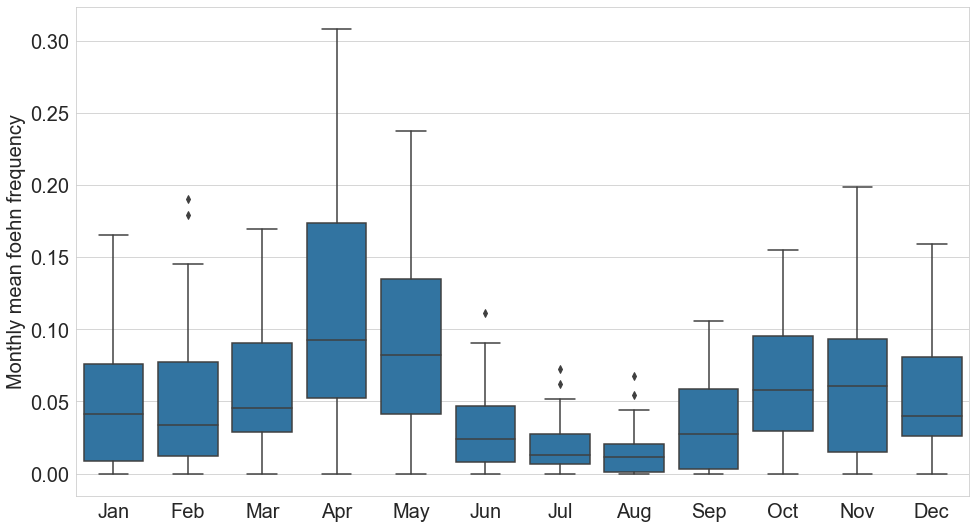

In [11]:
plot_monthly_foehn_distribution(df_1981_2019, location=location)

# Write output

In [12]:
df_foehn.to_csv(os.path.join(BASE_DIR, "data", "FoehnData", f"{location}_foehn.csv"), index=False)

# Make combined dataframe of ERAI and foehn data

In [12]:
df_ERA = pd.read_csv(os.path.join(BASE_DIR, "data", "MeteorologicalData", "ERAI_data.csv.gz"), parse_dates=["date"])
df_foehn = df_foehn.dropna()  # Drop missing values
df_ERA_merged = pd.merge(df_foehn, df_ERA, on="date", how="inner")  # Merge where both dataframes have non-missing values
df_ERA_merged.to_csv(os.path.join(BASE_DIR, "data", "FoehnAndMeteorologicalData", f"ERAI_and_{location}_data.csv.gz"), index=False)